$$\log p(\phi | \{x_i\}) \approx \prod\limits_{i=1}^N \frac{1}{S_i} \sum\limits_{j=1}^{S_i} p(\theta_{ij} | \phi)$$

For normalizing flows 
$$p(\theta_{ij} | \phi) = q_\phi(\theta_{ij})$$

Then a MAP solution for $\phi$ can be obtained by maximizing $\log p(\phi | \{ x_i \})$, which is equivalent to maximizing
$$\sum_{i=1}^N \log \sum\limits_{j=1}^S q_\phi(\theta_{ij})$$


In [1]:
import os
import h5py 
import glob
import numpy as np

In [2]:
from nflows import transforms, distributions, flows

import torch
from torch import nn
from torch import optim
import torch.distributions as D

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/global/cfs/cdirs/desi/users/chahah/provabgs/svda/'

In [5]:
torch.cuda.is_available()

True

# compile $M_*$ posterior data

In [6]:
f = h5py.File('/global/cfs/cdirs/desi/users/chahah/provabgs/svda/provabgs-sv3-bright-10154.BGS_BRIGHT.hdf5', 'r')

In [7]:
logM_posteriors = []
for fpost in glob.glob(os.path.join(dat_dir, 'provabgs-*hdf5'))[:5]: 
    f = h5py.File(fpost, 'r')
    mcmc = f['samples'][...][:,-100:,:,0]
    
    logM_posteriors.append(mcmc.reshape((mcmc.shape[0], mcmc.shape[1] * mcmc.shape[2])))
logM_posteriors = np.concatenate(logM_posteriors, axis=0)

(8.0, 12.5)

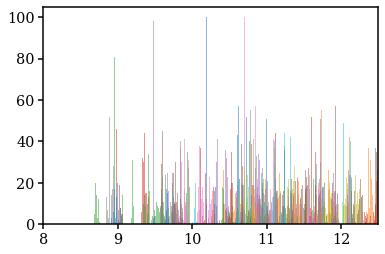

In [8]:
for i in np.random.choice(np.arange(logM_posteriors.shape[0]), size=100, replace=False): 
    plt.hist(logM_posteriors[i,::10], bins=40, alpha=0.5)
plt.xlim(8., 12.5)

# estimate $p(M_* | \{x_i, z_i \})$ using NDE

In [9]:
#device = 'cpu' 
device = torch.device(type='cuda', index=0)

In [10]:
x_data = torch.tensor(logM_posteriors.astype(np.float32)).to(device)
avg_post = torch.mean(x_data, axis=0)
std_post = torch.std(x_data, axis=0)
w_post = (x_data - avg_post)/std_post

/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/torch/cuda/__init__.py:145: UserWarning: 
NVIDIA A100-SXM4-40GB with CUDA capability sm_80 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA A100-SXM4-40GB GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


KeyboardInterrupt: 

In [25]:
def Loss(flow, post): 
    return -torch.sum(torch.logsumexp(flow.log_prob(post.flatten()[:,None]).reshape(post.shape), axis=1) - torch.log(torch.tensor(100.)))

In [17]:
ndim = 1 

In [18]:
nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(256)))))

blocks = []
for iblock in range(5): 
    blocks += [
        transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
        transforms.RandomPermutation(features=ndim)
    ]

transform = transforms.CompositeTransform(blocks)

# Define a base distribution.
base_distribution = distributions.StandardNormal(shape=[ndim])

In [26]:
all_flows = []

lr = 1e-3
num_iter = 1000
patience = 20

best_valid_losses, valid_losseses = [], []
for i in range(1): 
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(256)))))

    blocks = []
    for iblock in range(5): 
        blocks += [
            transforms.MaskedAffineAutoregressiveTransform(features=ndim, hidden_features=nhidden),
            transforms.RandomPermutation(features=ndim)
        ]

    transform = transforms.CompositeTransform(blocks)

    # Define a base distribution.
    base_distribution = distributions.StandardNormal(shape=[ndim])

    # Combine into a flow.
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    flow.to(device)

    # parameters = [weights, means, stdevs]
    optimizer1 = optim.Adam(flow.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer1, lr, total_steps=num_iter)

    best_epoch = 0 
    best_valid_loss = np.inf
    valid_losses = []
    for epoch in range(num_iter):
        train_loss = 0.
        for ii in range(90): 
            optimizer1.zero_grad()
            loss = Loss(flow, w_post[:,ii::100])
            loss.backward()
            train_loss += loss.item()
            optimizer1.step()
        train_loss = train_loss/90.

        with torch.no_grad():
            valid_loss = 0.
            for ii in range(10): 
                loss = Loss(flow, w_post[:,90+ii::100])
                valid_loss += loss.item()
            valid_loss = valid_loss/10.            
            valid_losses.append(valid_loss)
            if epoch % 20 == 0: 
                print('%i \t %.2e \t %.2e' % (epoch, train_loss, valid_loss))
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                best_epoch = epoch
            else: 
                if best_epoch < epoch - patience: 
                    print('>>>%i \t %.5e' % (epoch, best_valid_loss))
                    break
                    
        scheduler.step()
    all_flows.append(flow)
    valid_losseses.append(valid_losses)        

0 	 3.76e+03 	 3.03e+03


KeyboardInterrupt: 